<h1>
<center>
Predicting House Sale Price
</center>
</h1>

## 1. Predicting House Sale Prices

We will work with housing data for the city of Ames, Iowa, USA, from 2006 to 2010. The data was collected for research purposes; the resulting article can be found [here](http://ww2.amstat.org/publications/jse/v19n3/decock.pdf). Information about the different columns in the data can be found [here](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt)

We will set up a pipeline of functions that will let us quickly iterate on different models :  

<img src="https://s3.amazonaws.com/dq-content/240/pipeline.svg" alt="Pipeline" width="200" align="middle" />

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette("husl")
sns.set_style("white")

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv("AmesHousing.tsv", delimiter ="\t")
df.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
      

## 2. Feature Engineering


#### Steps to create the transform_features function

Let's remove features with many missing values, diving deeper into potential categorial features, and transforming text and numerical columns. 
We want to update transform_features() so that any column from the data frame with more than 25% (or another cutoff value) missing value is dropped. 
We'll also remove any columns that leak information about the sale. The goal is to :
- Remove Features that we don't want to use in the model, just based on the number of missing values or data leakage
- Transform features into the proper format (numerical to categorical, scaling numerical, filling in missing values, etc.)
- Create new features by combining other features

In [3]:
def transform_features(df, percent_missing=5):
    
    # Drop numerical columns with more than 5% missing value (can be changed in parameter)
    missing_value_count = df.isnull().sum()
    more_than_5_percent = missing_value_count[missing_value_count > len(df) * percent_missing/100]
    
    df = df.drop(more_than_5_percent.index, axis=1)
    
    # Drop text values with any missing data
    text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]
    df = df.drop(drop_missing_cols_2.index, axis=1)
    
    # Replace numerical columns that has missing data with the most frequent ones
    num_missing = df.select_dtypes(include=["integer", "float"]).isnull().sum() 
    fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)]
    replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient="records")[0]
    df = df.fillna(replacement_values_dict)
    
    # Replace years by duration, drop negative values
    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod
    df = df.drop([1702, 2180, 2181], axis=0)
    
    # Drop columns not useful for machine learning or that leak data about the final sale
    df = df.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type", "Year Built", "Year Remod/Add"], axis=1)
    
    return df

## 3. Feature Selection
### Steps to create the select_features function
Let's generate a correlation heatmap matrix of the numerical features in the training dataset. 

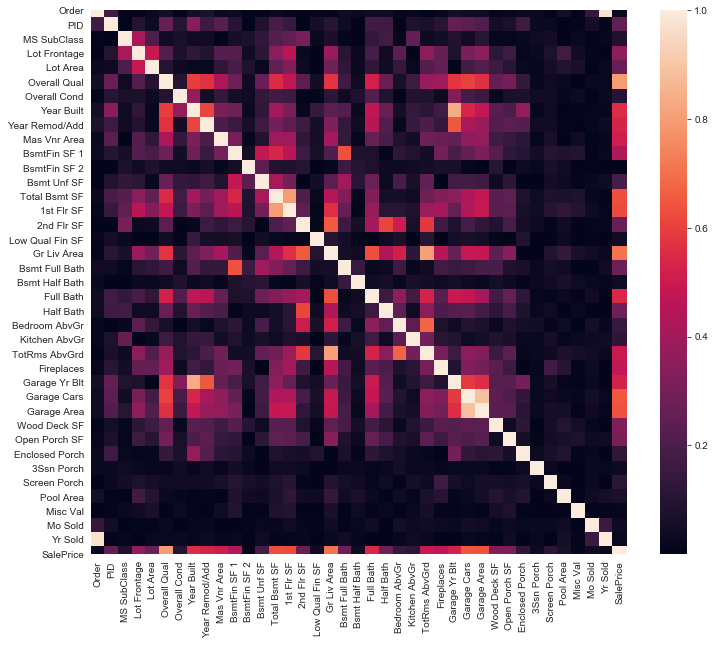

In [4]:
numerical_df = df.select_dtypes(include=['int', 'float'])
numerical_corr = numerical_df.corr().abs()
plt.figure(figsize=(12, 10))
sns.heatmap(numerical_corr);

Let's calculate the correlation coefficients with our target column : SalePrice

In [5]:
abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values(ascending=False)
abs_corr_coeffs

SalePrice          1.000000
Overall Qual       0.799262
Gr Liv Area        0.706780
Garage Cars        0.647877
Garage Area        0.640401
Total Bsmt SF      0.632280
1st Flr SF         0.621676
Year Built         0.558426
Full Bath          0.545604
Year Remod/Add     0.532974
Garage Yr Blt      0.526965
Mas Vnr Area       0.508285
TotRms AbvGrd      0.495474
Fireplaces         0.474558
BsmtFin SF 1       0.432914
Lot Frontage       0.357318
Wood Deck SF       0.327143
Open Porch SF      0.312951
Half Bath          0.285056
Bsmt Full Bath     0.276050
2nd Flr SF         0.269373
Lot Area           0.266549
PID                0.246521
Bsmt Unf SF        0.182855
Bedroom AbvGr      0.143913
Enclosed Porch     0.128787
Kitchen AbvGr      0.119814
Screen Porch       0.112151
Overall Cond       0.101697
MS SubClass        0.085092
Pool Area          0.068403
Low Qual Fin SF    0.037660
Bsmt Half Bath     0.035835
Mo Sold            0.035259
3Ssn Porch         0.032225
Order              0

We'll choose to keep features with a correlation coefficient more than 0.4 .After reading the documentation, the categorical columns that we'll keep are the following : 

In [6]:
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

If a categorical column has hundreds of unique values (or categories), should we keep it? When we dummy code this column, hundreds of columns will need to be added back to the data frame.We decided to keep 10 unique values.
Select the remaining text column, convert it to categorical and them create dummy columns. Thus, the second function of the pipeline is : 

In [7]:
def select_features(df, coeff_threshold=0.4, uniq_threshold=10):
    
    # keep features with a correlation coefficient more than 0.4 (can be changed in parameter)
    numerical_df = df.select_dtypes(include=['int', 'float'])
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < coeff_threshold].index, axis=1)
    
    # Nominal feature we'll keep
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    # Keep categorical values with less than 10 unique values (can be changed in parameter)
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)

    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    
    #Select the remaining text column, convert it to categorical and them create dummy columns.
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1)
    
    return df

## 4. Train and test function
Let's add some validation options to our train and test function. We'll add a k parameter to our function.

When k = 0, we'll perform holdout validation, with the first 1460 rows as train data, and the remaining for testing. 

When k = 1, we'll perform simple cross validation.

When k is greater than 1, we'll implement k-fold cross validation using k folds. 

In [8]:
def train_and_test(df, k=0):
    numeric_df = df.select_dtypes(include=['integer', 'float'])
    features = numeric_df.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]

        lr.fit(train[features], train["SalePrice"])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test["SalePrice"], predictions)
        rmse = np.sqrt(mse)

        return rmse
    
    if k == 1:
        shuffled_df = df.sample(frac=1, )
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train["SalePrice"])
        predictions_one = lr.predict(test[features])        
        
        mse_one = mean_squared_error(test["SalePrice"], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(test[features], test["SalePrice"])
        predictions_two = lr.predict(train[features])        
       
        mse_two = mean_squared_error(train["SalePrice"], predictions_two)
        rmse_two = np.sqrt(mse_two)
        
        avg_rmse = np.mean([rmse_one, rmse_two])

        return avg_rmse
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)

        avg_rmse = np.mean(rmse_values)
        return avg_rmse

Let's test the function on the dataset

In [9]:
transformed = transform_features(df)
selected = select_features(transformed)
rmse = train_and_test(selected)
rmse

33367.28718340335

## 5. Select the best model to predict house sale price 

In the following example, we'll study the differences in RMSE as k varies. It would be interesting to change the feature functions parameters. 

Text(0, 0.5, 'RMSE')

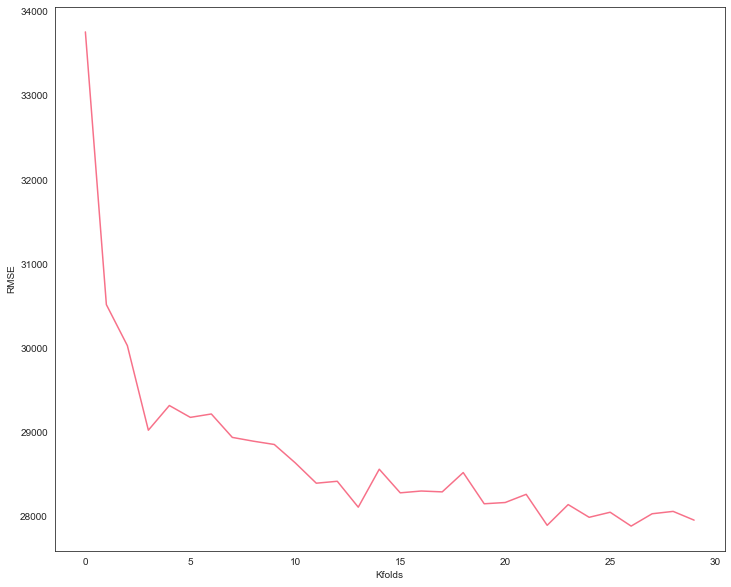

In [10]:
data = pd.read_csv("AmesHousing.tsv", delimiter='\t')

transformed_data = transform_features(data, percent_missing=0.05)
final_data = select_features(transformed_data, 0.4, 10)

results = []
for i in range(30):
    result = train_and_test(final_data, k=i)
    results.append(result)
    
x = [i for i in range(30)]
y = results 

plt.figure(figsize=(12, 10))
plt.plot(x, y)
plt.xlabel('Kfolds')
plt.ylabel('RMSE')